In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy.stats import hypergeom
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import importlib.util
import multiprocessing

import warnings; warnings.simplefilter('ignore')
%reload_ext rpy2.ipython

In [2]:
data_dir = os.environ['DATA_DIR']
img_dir = os.environ['IMG_DIR']
nb_dir = os.path.join(os.path.split(data_dir)[0], 'notebooks')

cpus = multiprocessing.cpu_count()
if cpus > 1:
    cpus -= 1
spec = importlib.util.spec_from_file_location("ActivityLearner", os.path.join(nb_dir, "neural_net.py"))
ann = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ann)

spece = importlib.util.spec_from_file_location("Enrichment", os.path.join(nb_dir, "enrichment.py"))
enrm = importlib.util.module_from_spec(spece)
spece.loader.exec_module(enrm)

In [3]:
strains_fp = os.path.join(data_dir, 'isolates.tsv')
bgc_pa_file = os.path.join(data_dir, 'bgc_presence_absence.tsv')
cv_scores_file = os.path.join(data_dir, 'cross_validation_scores.tsv')
gcv_scores_file = os.path.join(data_dir, 'genus_cross_validation_scores.tsv')
model_cv_img_fp = os.path.join(img_dir, 'model_cv.png')
tax_correlation_img_fp = os.path.join(img_dir, 'tax_correlation.png')
tax_exclusion_img_fp = os.path.join(img_dir, 'tax_exclusion.png')

In [4]:
bgc_pa_df = pd.read_csv(bgc_pa_file, sep='\t', index_col=0)
bgc_pa_df.head(3)

,SID00260,SID01183,SID00110,SID00247,SID00461,SID01042,SID00837,SID00708,SID00088,SID00970,...,SID01038,SID00673,SID01137,SID00281,SID00744,SID00143,SID01091,SID01076,SID00354,SID00907
fam_cluster_id,,,,,,,,,,,,,,,,,,,,,
nrps10000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nrps10007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nrps10030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
strains_df = pd.read_csv(strains_fp, sep='\t')
strains_df.head(3)

,strain_id,selection_tool,sample_type,country,state,phylum,class,order,family,genus,...,sa_confirmed_activity,sa_purity_test,sa_purity_confirmed,bs_primary_test,bs_confirmation_test,bs_confirmed_activity,bs_purity_test,bs_purity_confirmed,sa_ml_disease_ctrl,bs_ml_disease_ctrl
0,SID00001,genome_similarity,Soil,Uganda,Amuria,Firmicutes,Bacilli,Bacillales,Bacillaceae_H,Bacillus_C,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,SID00002,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,35.0
2,SID00003,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,1,1,1,1.0,1.0,1.0,1.0,1.0,NaN,80.0


### Cross Validation of strain prioritization methods

On average, which modeling approach will perform best?

In [6]:
training_strains = strains_df[(strains_df.selection_tool.isin(['diversity'])) &
                              (strains_df.strain_id.isin(bgc_pa_df.columns.tolist()))
                             ]

sa_training_strains = training_strains.query('sa_primary_test == 1')
sa_active_strains = training_strains.query('sa_confirmation_test == 1')
print(sa_active_strains.shape[0])

28


In [7]:
bgc_pa_T = bgc_pa_df.T
bgc_pa_T.index.name = 'strain_id'
sa_bgc_pa_T = bgc_pa_T.loc[sa_training_strains.strain_id]
sa_bgc_pa_T['activity'] = sa_bgc_pa_T.apply(lambda row: row.name in sa_active_strains.strain_id.tolist(), axis=1)
sa_bgc_features = sa_bgc_pa_T.drop('activity', axis=1)
sa_bgc_activity = sa_bgc_pa_T[['activity']]
active_likelihood_primary_screen = sa_bgc_activity.sum().values[0] / sa_bgc_activity.shape[0]
print(sa_bgc_features.shape, sa_bgc_activity.shape, active_likelihood_primary_screen)

(546, 2770) (546, 1) 0.0512820512821


#### Learning/Prediction methods

In [8]:
def get_er_prediction(x_train, y_train, x_test, y_test):
    tmp_enrichment_df = enrm.calc_enrichment_scores(x_train.shape[0], 
                                                    y_train.sum(), 
                                                    x_train.T, 
                                                    x_train[y_train.values].T)
    top10_enriched = tmp_enrichment_df.sort_values(by=['fdr_corrected_pval']).head(10).index
    enriched_strains = x_test[top10_enriched]
    enriched_strains['sum_ebgcs'] = enriched_strains.apply(lambda x: sum(x), axis=1)
    enriched_strains['predicted_activity'] = False
    # Simple criteria: any strain with 1 or more "enriched" BGCs we predict to be active
    enriched_strains[enriched_strains.sum_ebgcs > 0] = True
    er_prediction = enriched_strains.loc[y_test.index][['predicted_activity']]
    
    # Anything not explicitely predicted to be active is assumed to be inactive
    er_prediction[er_prediction.isna()] = False
    er_prediction = er_prediction.astype(bool)
    assert er_prediction.shape[0] == y_test.shape[0]
    return er_prediction, top10_enriched

def calc_permutation_importances(model, x, y):
    tmp_r = permutation_importance(model, x, y,
                                   n_repeats=10,
                                   n_jobs=cpus,
                                   scoring='f1',
                                   random_state=0)
    
    importances_df = (pd.DataFrame({'fam_cluster_id':x_train.columns, 
                                    'rf_importance':tmp_r.importances_mean})
                      .sort_values(by='rf_importance', ascending=False)
                      .set_index('fam_cluster_id')
                     )
    tmp_fi99 = importances_df[importances_df.rf_importance > importances_df.rf_importance.quantile(0.99)].index.tolist()
    return tmp_fi99

def get_rf_prediction(x_train, y_train, x_test, y_test, top10_er):    
    # Select 99th percentile BGCs and combine with enriched BGCs
    tmp_rf = RandomForestClassifier(n_estimators=5, 
                                    max_depth=32,
                                    random_state=200602)

    tmp_rf.fit(x_train, y_train)    
    
    tmp_fi99 = calc_permutation_importances(tmp_rf, x_train, y_train)
    top_features = list(set(tmp_fi99 + top10_er.tolist()))
    
    # Train and predict
    tmp_rf.fit(x_train[top_features], y_train)
    rf_prediction = tmp_rf.predict(x_test[top_features])
    assert rf_prediction.shape[0] == y_test.shape[0]
    return rf_prediction, top_features

def get_rfos_prediction(x_train, y_train, x_test, y_test, top10_er, osf=13):    
    # Select 99th percentile BGCs and combine with enriched BGCs
    tmp_rf = RandomForestClassifier(n_estimators=5, 
                                    max_depth=32,
                                    random_state=200602)

    tmp_rf.fit(x_train, y_train)    
    tmp_fi99 = calc_permutation_importances(tmp_rf, x_train, y_train)
    top_features = list(set(tmp_fi99 + top10_er.tolist()))
    
    x_train_top = x_train[top_features]
    actives_top = x_train_top[y_train.activity]
    actives_oversampled = [actives_top] * osf
    os_x = pd.concat([x_train_top] + actives_oversampled)

    new_ys = pd.DataFrame([True]*(actives_top.shape[0] * osf),
                          columns=['activity'])
    os_y = pd.concat([y_train, new_ys])
    os_y.index = os_x.index    
    
    # Train and predict
    tmp_rf.fit(os_x, os_y)
    rf_prediction = tmp_rf.predict(x_test[top_features])
    assert rf_prediction.shape[0] == y_test.shape[0]
    return rf_prediction, top_features

def get_nn_prediction(x_train, y_train, x_test, y_test, top_features):
    x_train_top = x_train[top_features]
    x_test_top = x_test[top_features]
    sa_nn = ann.ActivityLearner(n_features=len(top_features))
    sa_nn.model.fit(x_train_top.values.astype(np.float32), y_train.values.astype(np.float32))
    nn_prediction = sa_nn.model.predict(x_test_top.values.astype(np.float32))
    nn_prediction = nn_prediction > np.mean(nn_prediction)
    assert nn_prediction.shape[0] == y_test.shape[0]
    return nn_prediction

def get_random_prediction(x_test, y_test, active_likelihood=active_likelihood_primary_screen):
    simul_pred = np.random.choice([True, False], 
                                   size=y_test.shape[0],
                                   replace=True,
                                   p=[active_likelihood, 1 - active_likelihood]
                                  )
    assert simul_pred.shape[0] == y_test.shape[0]
    return simul_pred

def get_tax_similarity(x_train, x_test):
    # Jaccard similarity index between the taxonomic assignments
    # of training and test strains
    train_genera = set(strains_df[strains_df.strain_id.isin(x_train.index)].genus.tolist())
    test_genera = set(strains_df[strains_df.strain_id.isin(x_test.index)].genus.tolist())
    return len(train_genera.intersection(test_genera)) / len(train_genera.union(test_genera))

In [ ]:
# Simulate model performance many times (cross validation)
model_scores = {'model':[], 'f1':[], 'p':[], 'r':[], 'tax_sim':[]}

def add_row(model_type, predictions, y_truth, tax_sim):
    model_scores['model'].append(model_type)
    model_scores['f1'].append(f1_score(y_pred=predictions, y_true=y_truth))
    model_scores['p'].append(precision_score(y_pred=predictions, y_true=y_truth))
    model_scores['r'].append(recall_score(y_pred=predictions, y_true=y_truth))
    model_scores['tax_sim'].append(tax_sim)

for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(sa_bgc_features, 
                                                        sa_bgc_activity, 
                                                        test_size=0.25, 
                                                        random_state=200602+i)
    
    # Calculate similarity between taxa in train and test
    tax_similarity = get_tax_similarity(x_train, x_test)
    
    # Identify top 10 enriched BGCs and predict
    # test strains with those BGCs
    er_prediction, top10_enriched = get_er_prediction(x_train, y_train, x_test, y_test)
    add_row('ER', er_prediction, y_test, tax_similarity)

    # Train RF, keep top 99th percentile BGCs according to 
    # feature importance, predict test strain activity
    rf_prediction, top_features = get_rf_prediction(x_train, y_train, x_test, y_test, top10_enriched)    
    add_row('RF', rf_prediction, y_test, tax_similarity)
    
    # Train RF using oversampled actives (to increase recall)
    rfos_prediction, _ = get_rfos_prediction(x_train, y_train, x_test, y_test, top10_enriched)    
    add_row('RFOS', rfos_prediction, y_test, tax_similarity)
    
    # Neural Net predictions
    nn_prediction = get_nn_prediction(x_train, y_train, x_test, y_test, top_features)
    add_row('NN', nn_prediction, y_test, tax_similarity)
    
    # Random predictions
    rnd_prediction = get_random_prediction(x_test, y_test)    
    add_row('Rand', rnd_prediction, y_test, tax_similarity)
    
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.to_csv(cv_scores_file, sep='\t', index=False)
model_scores_df.head()

In [9]:
# Load data from TSV instead of waiting hours for simulations to run
model_scores_df = pd.read_csv(cv_scores_file, sep='\t')

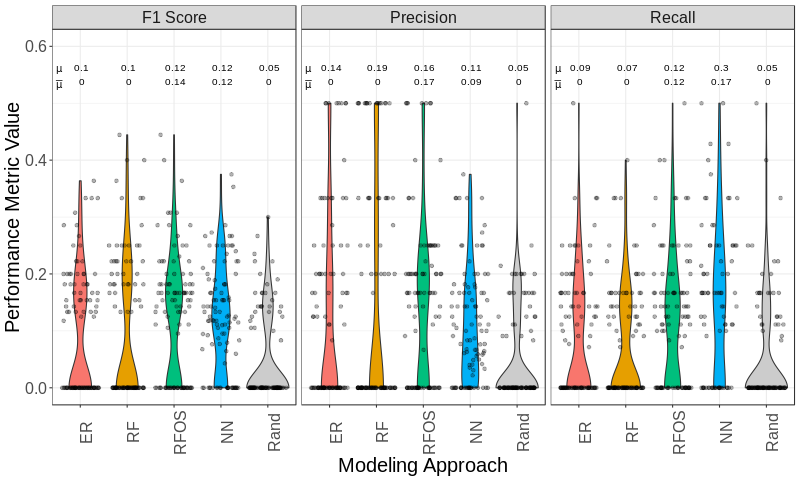

In [63]:
%%R -i model_scores_df -w 800
library(tidyverse)

long = model_scores_df %>%
    gather('metric', 'value', f1, p, r)

labels = long %>%
    group_by(model, metric) %>%
    summarise(val_mean = round(mean(value),2), 
              val_median = round(median(value),2)) %>%
    mutate(y = 0.55, ave_lab = paste0(' ', val_mean, '\n ', val_median))
    
long$metric = factor(long$metric)
long$model = factor(long$model, levels = c('ER', 'RF', 'RFOS', 'NN', 'Rand'))
levels(long$metric) = c('F1 Score', 'Precision', 'Recall')
labels$metric = factor(labels$metric)
labels$model = factor(labels$model, levels = c('ER', 'RF', 'RFOS', 'NN', 'Rand'))
levels(labels$metric) = c('F1 Score', 'Precision', 'Recall')


ggplot(long, aes(x=factor(model), y=value)) +
    geom_violin(aes(fill=model)) +
    scale_fill_manual(values=c('#f8766d', '#E69F00', '#00bf7d', '#00b0f6', '#cccccc')) +
    geom_jitter(alpha=0.3, height=0) +
    labs(x='Modeling Approach',
         y='Performance Metric Value') +
    geom_text(data=labels, size=3.5, hjust='middle', aes(x=model, y=y, label=ave_lab)) +
    annotate("text", x = 0.55, y = 0.545, size=3.5, label = expression(atop(mu, bar(mu)))) +
    theme_bw() +
    ylim(0,0.6) +
    facet_wrap(~metric) + 
    theme(text = element_text(size=20),
          legend.position = "none",
          axis.text.x = element_text(angle = 90))

In [64]:
%%R -i model_cv_img_fp

ggsave(model_cv_img_fp, height=4, width=7)

In [12]:
model_scores_df.query('model == "Rand"').f1.mean()

0.04824528653321223

In [13]:
model_scores_df.query('model == "Rand"').r.mean()

0.053837662337662337

In [14]:
model_scores_df.query('model == "NN"').r.mean() / model_scores_df.query('model == "Rand"').r.mean(), \
model_scores_df.query('model == "RFOS"').r.mean() / model_scores_df.query('model == "Rand"').r.mean()

(5.6097622073981999, 2.2425722671169539)

In [15]:
er_f1 = model_scores_df.query('model == "ER"').f1
rf_f1 = model_scores_df.query('model == "RF"').f1
rfos_f1 = model_scores_df.query('model == "RFOS"').f1
nn_f1 = model_scores_df.query('model == "NN"').f1
rnd_f1 = model_scores_df.query('model == "Rand"').f1
stats.kruskal(er_f1, rf_f1, rfos_f1, nn_f1, rnd_f1).pvalue

2.8956527314628976e-07

In [16]:
models = model_scores_df.model.unique()
stat_tests = np.zeros([len(models), len(models)])
for i, m_i in enumerate(models):
    for j, m_j in enumerate(models):
        f1_i = model_scores_df.query(f'model == "{m_i}"').f1
        f1_j = model_scores_df.query(f'model == "{m_j}"').f1
        if f1_i.equals(f1_j):
            p = 1
        else:
            p = stats.mannwhitneyu(f1_i, f1_j, alternative='greater').pvalue
        stat_tests[i, j] = p
stat_tests_df = pd.DataFrame(data=stat_tests, index=models, columns=models)
stat_tests_df

,ER,RF,RFOS,NN,Rand
ER,1.000000,0.502656,0.967322,0.966857,4.622528e-04
RF,0.498407,1.000000,0.949169,0.980018,1.825480e-03
RFOS,0.032865,0.051101,1.000000,0.363289,4.623728e-08
NN,0.033329,0.020105,0.637641,1.000000,6.866802e-09
Rand,0.999542,0.998191,1.000000,1.000000,1.000000e+00


The likelihood that the distribution of F1 values from the model on the row is greater than that of the model on the column by random chance.
e.g. RF and NN both have low p-values with respect to Rand because the distributions are so different that they are unlikely to have occurred by random chance.

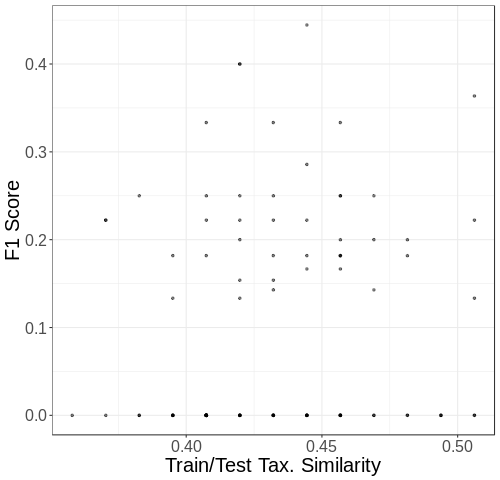

In [17]:
%%R -w 500

ggplot(model_scores_df %>% filter(model == "RF"), aes(x=tax_sim, y=f1)) +
    geom_point(size=1, alpha=0.5) +
    labs(x='Train/Test Tax. Similarity',
         y='F1 Score') +
    theme_bw() +
    theme(text = element_text(size=20),
          legend.position = "none")

In [18]:
%%R -i tax_correlation_img_fp

ggsave(tax_correlation_img_fp, height=4, width=4)

In [19]:
f1 = model_scores_df.query('model == "RF"').f1
tax_sim = model_scores_df.query('model == "RF"').tax_sim
stats.spearmanr(f1, tax_sim)

SpearmanrResult(correlation=0.13375127253625857, pvalue=0.18461907747120235)

### Remove taxonomic correlations up to genus level and evaluate model performance

In [20]:
# Simulate model performance many times (cross validation)
model_tax_scores = {'model':[], 'f1':[], 'p':[], 'r':[], 'tax_excluded':[]}

def add_tax_row(model_type, predictions, y_truth, tax_ex):
    model_tax_scores['model'].append(model_type)
    model_tax_scores['f1'].append(f1_score(y_pred=predictions, y_true=y_truth))
    model_tax_scores['p'].append(precision_score(y_pred=predictions, y_true=y_truth))
    model_tax_scores['r'].append(recall_score(y_pred=predictions, y_true=y_truth))
    model_tax_scores['tax_excluded'].append(tax_ex)

genera = sa_training_strains.genus.unique()
for g in genera:
    in_g = sa_training_strains.query(f'genus != "{g}"')
    out_g = sa_training_strains.query(f'genus == "{g}"')
    x_train = sa_bgc_features.loc[in_g.strain_id]
    x_test = sa_bgc_features.loc[out_g.strain_id]
    y_train = sa_bgc_activity.loc[in_g.strain_id]
    y_test = sa_bgc_activity.loc[out_g.strain_id]
    print(g, x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    if y_test.shape[0] > 0:
        # Calculate similarity between taxa in train and test
        tax_similarity = get_tax_similarity(x_train, x_test)

        # Identify top 10 enriched BGCs and predict
        # test strains with those BGCs
        er_prediction, top10_enriched = get_er_prediction(x_train, y_train, x_test, y_test)
        add_tax_row('ER', er_prediction, y_test, g)

        # Train RF, keep top 99th percentile BGCs according to 
        # feature importance, predict test strain activity
        rf_prediction, top_features = get_rf_prediction(x_train, y_train, x_test, y_test, top10_enriched)    
        add_tax_row('RF', rf_prediction, y_test, g)
        
        # Train RF using oversampled actives (to increase recall)
        rfos_prediction, _ = get_rfos_prediction(x_train, y_train, x_test, y_test, top10_enriched)    
        add_tax_row('RFOS', rfos_prediction, y_test, g)
        
        # Neural Net predictions
        nn_prediction = get_nn_prediction(x_train, y_train, x_test, y_test, top_features)
        add_tax_row('NN', nn_prediction, y_test, g)
        
        # Random predictions
        rnd_prediction = get_random_prediction(x_test, y_test)    
        add_tax_row('Rand', rnd_prediction, y_test, g)
    
model_tax_scores_df = pd.DataFrame(model_tax_scores)
model_tax_scores_df.to_csv(gcv_scores_file, sep='\t', index=False)
model_tax_scores_df.head()

Acinetobacter (536, 2770) (536, 1) (10, 2770) (10, 1)
Herbaspirillum (536, 2770) (536, 1) (10, 2770) (10, 1)
Variovorax (495, 2770) (495, 1) (51, 2770) (51, 1)
Pseudomonas_E (469, 2770) (469, 1) (77, 2770) (77, 1)
Lysinibacillus (533, 2770) (533, 1) (13, 2770) (13, 1)
B6 (545, 2770) (545, 1) (1, 2770) (1, 1)
Pantoea (543, 2770) (543, 1) (3, 2770) (3, 1)
Bacillus (527, 2770) (527, 1) (19, 2770) (19, 1)
Pseudarthrobacter (519, 2770) (519, 1) (27, 2770) (27, 1)
Microbacterium (529, 2770) (529, 1) (17, 2770) (17, 1)
Enterobacter (502, 2770) (502, 1) (44, 2770) (44, 1)
Domibacillus (545, 2770) (545, 1) (1, 2770) (1, 1)
Klebsiella_B (526, 2770) (526, 1) (20, 2770) (20, 1)
Bacillus_A (516, 2770) (516, 1) (30, 2770) (30, 1)
Curtobacterium (540, 2770) (540, 1) (6, 2770) (6, 1)
Mucilaginibacter (545, 2770) (545, 1) (1, 2770) (1, 1)
Bacillus_C (522, 2770) (522, 1) (24, 2770) (24, 1)
Thermomonas (544, 2770) (544, 1) (2, 2770) (2, 1)
Raoultella (539, 2770) (539, 1) (7, 2770) (7, 1)
Paenibacillus (5

,model,f1,p,r,tax_excluded
0,ER,0.0,0.0,0.0,Acinetobacter
1,RF,0.0,0.0,0.0,Acinetobacter
2,RFOS,0.0,0.0,0.0,Acinetobacter
3,NN,0.0,0.0,0.0,Acinetobacter
4,Rand,0.0,0.0,0.0,Acinetobacter


In [21]:
# Load data from TSV instead of waiting hours for simulations to run
model_tax_scores_df = pd.read_csv(gcv_scores_file, sep='\t')

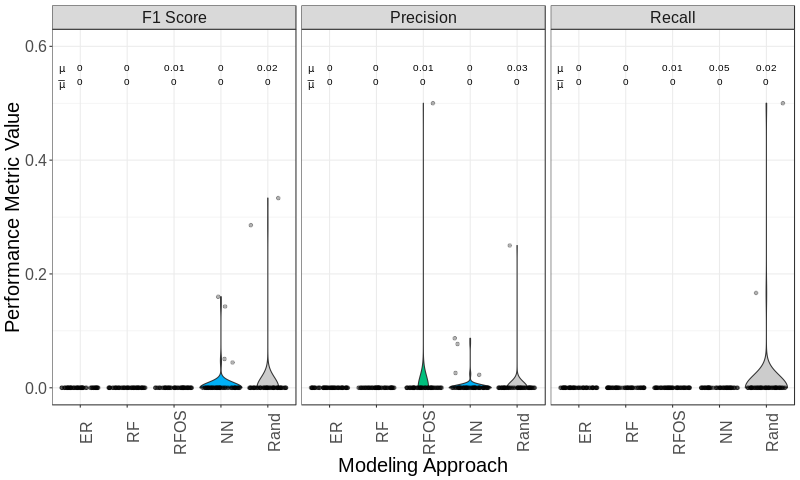

In [49]:
%%R -i model_tax_scores_df -w 800

longt = model_tax_scores_df %>%
    gather('metric', 'value', f1, p, r)


labelst = longt %>%
    group_by(model, metric) %>%
    summarise(val_mean = round(mean(value),2), 
              val_median = round(median(value),2)) %>%
    mutate(y = 0.55, ave_lab = paste0(val_mean, '\n', val_median))
    
longt$metric = factor(longt$metric)
longt$model = factor(longt$model, levels = c('ER', 'RF', 'RFOS', 'NN', 'Rand'))
levels(longt$metric) = c('F1 Score', 'Precision', 'Recall')
labelst$metric = factor(labelst$metric)
labelst$model = factor(labelst$model, levels = c('ER', 'RF', 'RFOS', 'NN', 'Rand'))
levels(labelst$metric) = c('F1 Score', 'Precision', 'Recall')

ggplot(longt, aes(x=factor(model), y=value)) +
    geom_violin(aes(fill=model)) +
    scale_fill_manual(values=c('#f8766d', '#E69F00', '#00bf7d', '#00b0f6', '#cccccc')) +
    geom_jitter(alpha=0.3, height=0) +
    labs(x='Modeling Approach',
         y='Performance Metric Value') +
    geom_text(data=labelst, size=3.5, hjust='middle', aes(x=model, y=y, label=ave_lab)) +
    annotate("text", x = 0.6, y = 0.545, size=3.5, label = expression(atop(mu, bar(mu)))) +
    theme_bw() +
    ylim(0,0.6) +
    facet_wrap(~metric) + 
    theme(text = element_text(size=20),
          legend.position = "none",
          axis.text.x = element_text(angle = 90))

In [50]:
%%R -i tax_exclusion_img_fp

ggsave(tax_exclusion_img_fp, height=4, width=7)

In [24]:
ert = model_tax_scores_df.query('model == "ER"').f1
rft = model_tax_scores_df.query('model == "RF"').f1
rndt = model_tax_scores_df.query('model == "Rand"').f1
stats.kruskal(ert, rft, rndt).pvalue

0.048549342432101419